In [1]:
# ==========================================================
# Stock Next-Day Close Prediction
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

import joblib


In [14]:
# ==========================================================
# 1) Data Loading (Last 5 Years)
# ==========================================================

ticker = "INTELCORPORATION.NS"
period = "10y"  # exactly 10 years for efficiency

df = yf.download(ticker, period=period, interval="1d", auto_adjust=False)
df.dropna(inplace=True)

print("Ticker:", ticker)
print("Date Range:", df.index.min().date(), "to", df.index.max().date())
print("Shape:", df.shape)

df.head()


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: INTELCORPORATION.NS"}}}
$INTELCORPORATION.NS: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTELCORPORATION.NS']: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")


Ticker: INTELCORPORATION.NS
Date Range: NaT to NaT
Shape: (0, 6)


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,INTELCORPORATION.NS,INTELCORPORATION.NS,INTELCORPORATION.NS,INTELCORPORATION.NS,INTELCORPORATION.NS,INTELCORPORATION.NS
Date,,,,,,


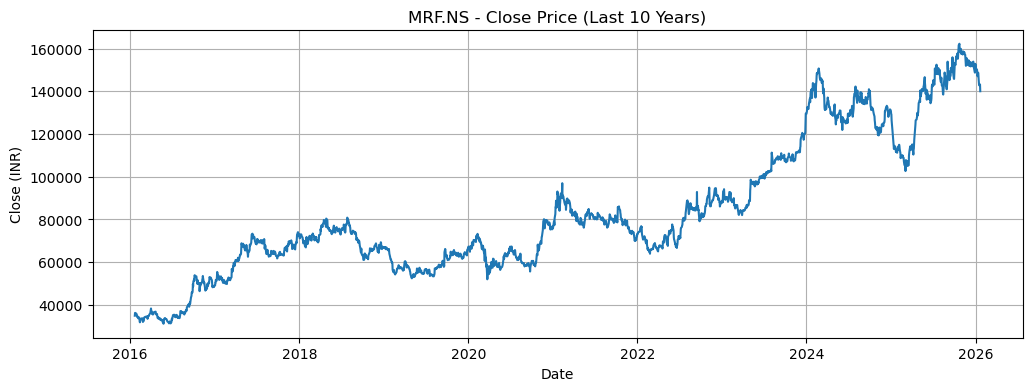

In [3]:
# ==========================================================
# 2) Data Visualization (Close Trend)
# ==========================================================

plt.figure(figsize=(12, 4))
plt.plot(df["Close"])
plt.title(f'{ticker} - Close Price (Last 10 Years)')
plt.xlabel("Date")
plt.ylabel("Close (INR)")
plt.grid(True)
plt.show()


In [4]:
# ==========================================================
# 3) Feature Engineering
# ==========================================================

data = df.copy()

# Basic derived features
data["Return_1d"] = data["Close"].pct_change()
data["HL_Range"] = data["High"] - data["Low"]
data["OC_Range"] = data["Open"] - data["Close"]

# Rolling statistics (trend + volatility)
for w in [5, 10, 20]:
    data[f"SMA_{w}"] = data["Close"].rolling(window=w).mean()
    data[f"STD_{w}"] = data["Close"].rolling(window=w).std()

# Lag features (memory)
for lag in [1, 2, 3, 5, 10]:
    data[f"Close_Lag_{lag}"] = data["Close"].shift(lag)
    data[f"Return_Lag_{lag}"] = data["Return_1d"].shift(lag)

# Target: Next-day close price
data["Target_Close_Next"] = data["Close"].shift(-1)

# Drop rows with NaNs caused by rolling/lags/shift
data.dropna(inplace=True)

data.head()


Price,Adj Close,Close,High,Low,Open,Volume,Return_1d,HL_Range,OC_Range,SMA_5,...,Return_Lag_1,Close_Lag_2,Return_Lag_2,Close_Lag_3,Return_Lag_3,Close_Lag_5,Return_Lag_5,Close_Lag_10,Return_Lag_10,Target_Close_Next
Ticker,MRF.NS,MRF.NS,MRF.NS,MRF.NS,MRF.NS,MRF.NS,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-18,32913.507812,33435.050781,33788.699219,33120.199219,33600.000000,3963,0.002782,668.500000,164.949219,33026.880078,...,0.003453,33227.550781,-0.002704,33317.648438,0.047335,32304.900391,-0.044950,33725.398438,-0.013913,33602.000000
2016-02-19,33077.863281,33602.000000,33810.000000,33010.000000,33100.000000,2935,0.004993,800.000000,-502.000000,33384.910156,...,0.002782,33342.300781,0.003453,33227.550781,-0.002704,31811.849609,-0.015262,34180.351562,0.013490,33729.898438
2016-02-22,33203.761719,33729.898438,34087.449219,33425.398438,33600.000000,2621,0.003806,662.050781,-129.898438,33467.360156,...,0.004993,33435.050781,0.002782,33342.300781,0.003453,33317.648438,0.047335,34140.148438,-0.001176,33589.000000
2016-02-23,33065.062500,33589.000000,34070.000000,33464.601562,33729.000000,3566,-0.004177,605.398438,140.000000,33539.650000,...,0.003806,33602.000000,0.004993,33435.050781,0.002782,33227.550781,-0.002704,33656.101562,-0.014178,32764.400391
2016-02-24,32253.324219,32764.400391,33790.000000,32515.050781,33400.050781,5353,-0.024550,1274.949219,635.650391,33424.069922,...,-0.004177,33729.898438,0.003806,33602.000000,0.004993,33342.300781,0.003453,33825.351562,0.005029,31977.699219


In [5]:
# ==========================================================
# 4) Time-Series Train/Test Split (No Shuffle)
# ==========================================================

feature_cols = [
    "Return_1d", "HL_Range", "OC_Range",
    "SMA_5", "SMA_10", "SMA_20",
    "STD_5", "STD_10", "STD_20",
    "Close_Lag_1", "Close_Lag_2", "Close_Lag_3", "Close_Lag_5", "Close_Lag_10",
    "Return_Lag_1", "Return_Lag_2", "Return_Lag_3", "Return_Lag_5", "Return_Lag_10"
]

X = data[feature_cols]
y = data["Target_Close_Next"]

split_idx = int(len(data) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (1960, 19) Test size: (491, 19)


In [6]:
# ==========================================================
# 5) Model Training (XGBoost Regressor)
# ==========================================================

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.035,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)

pred = model.predict(X_test)


In [7]:
# ==========================================================
# 6) Model Evaluation
# ==========================================================

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("MAE :", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R²  :", round(r2, 4))


MAE : 7245.357
RMSE: 10061.76
R²  : 0.4495


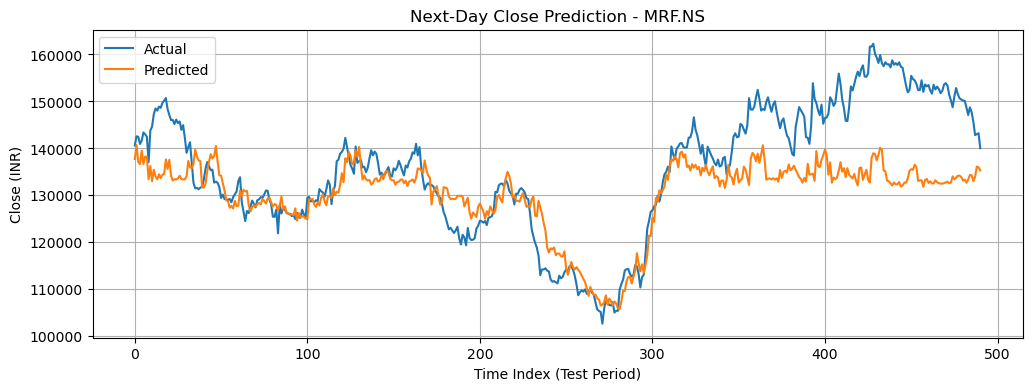

In [8]:
# ==========================================================
# 7) Visualization: Actual vs Predicted
# ==========================================================

plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="Actual")
plt.plot(pred, label="Predicted")
plt.title(f'Next-Day Close Prediction - {ticker}')
plt.xlabel("Time Index (Test Period)")
plt.ylabel("Close (INR)")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# ==========================================================
# 9) Predict Next Day Close (Latest Available Row)
# ==========================================================

latest_features = X.iloc[-1].values.reshape(1, -1)
next_close_prediction = model.predict(latest_features)[0]

print("Latest Close:", round(data['Close'].iloc[-1], 2))
print("Predicted Next Close: INR", round(next_close_prediction, 2))


Latest Close: Ticker
MRF.NS    143235.0
Name: 2026-01-20 00:00:00, dtype: float64
Predicted Next Close: INR 135313.12


In [10]:
# ==========================================================
# Save Model + Feature Columns (PKL)
# ==========================================================

import joblib

# Save the trained model
joblib.dump(model, "stock_xgb_model.pkl")

# Save feature columns (important for consistent prediction later)
joblib.dump(feature_cols, "stock_feature_cols.pkl")

print("Saved files:")
print("stock_xgb_model.pkl")
print("stock_feature_cols.pkl")


Saved files:
stock_xgb_model.pkl
stock_feature_cols.pkl
